In [1]:
import spacy
import pandas as pd
import numpy as np

import Modules.solrhandler as sh
#import Modules.decision_tree_bot as cb

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
#query = "anmeldung"
#target_service = 120686

In [76]:
# Import eval.csv
import os
file = os.path.realpath("../../Evaluierung/eval.csv")
eval = pd.read_csv(file, sep = ";")
eval = eval.head()
eval.head()

,documentId,file,dialogId,initialQuestion,suggestionCount,directlyFound,name
0,120697,20220131--quantEvalAllExcel.xlsx,4,Ummeldung,6,True,Änderung/Wechsel der Hauptwohnung
1,120686,20220131--quantEvalAllExcel.xlsx,4,Ummelden,6,True,Anmeldung einer Wohnung
2,329421,20220131--quantEvalAllExcel.xlsx,19,Pcr test positiv brauche ich eine Krankschreib...,6,False,Erstattung nach Infektionsschutzgesetz bei Tät...
3,329421,20220131--quantEvalAllExcel.xlsx,19,Quarantäne Krankschreibung vom Arzt,6,True,Erstattung nach Infektionsschutzgesetz bei Tät...
4,120914,20220131--quantEvalAllExcel.xlsx,23,Termin für Zulassung Gebrauchtwagen,6,True,Zulassung eines Fahrzeuges mit auswärtigem Ken...


Funktionen

In [101]:
def findCorrectAnswer(chatbot,targetService): # ALT

    # Find Target Cluster
    clusteredColumn = chatbot.clusterer.getClusteredColumn()
    service = chatbot.df.loc[chatbot.df["id"]==str(targetService)]
    if len(service[clusteredColumn].values) == 0:
        return None

    targetCluster = service[clusteredColumn].values[0]

    if targetCluster == chatbot.getSelectedClusterForQuestion():
        return True

    else:
        return False
    
def findCorrectAnswer(chatbot,targetService): # NEU
    temp = chatbot.df#.reset_index(drop=True)
    #index = np.where(temp["id"].values == targetService) # TODO
    print(temp["id"] == str(targetService))
    if(not any(temp["id"] == str(targetService))):
        print("not any")
        return None
    
    index = temp.index[temp["id"] == str(targetService)].tolist()[0]
    print(index)
    bin_vector = chatbot.getBinVector(right = True)
    if bin_vector[index] == 1:
        return True
    elif bin_vector[index] == 0:
        return False
    else:
        print("asdafasdg")
        return None
    

def getRank(chatbot, targetService):
    temp = chatbot.df#.reset_index()
    #print(temp["id"])
    #print(targetService)
    rank = temp.index[temp["id"]==str(targetService)].values[0]
    return rank

TEST

In [70]:
import spacy
import pandas as pd
import numpy as np

import Modules.solrhandler as sh
import Modules.clusterer as cls

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree

from sklearn.tree import export_text

import matplotlib.pyplot as plt


# TODO import jannis
def init_vector(df,col_name="ssdsLemma"):
    #initiates the word-occurence & frequency vector and list of words
    vectorizer = CountVectorizer()
    a = vectorizer.fit_transform(df[f"{col_name}_processed"]).toarray()
    b = a > 0
    word_occ = b.astype(int)
    words = vectorizer.get_feature_names()
    word_freq=word_occ.sum(axis=0).tolist()
    return word_occ, words, word_freq

class DecisionTreeChatbot:


    def __init__(self, tree_model = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 1), solr = sh.SolrHandler(5), nlp = spacy.load('de_core_news_lg')):
        self.tree_model = tree_model
        self.solr = solr
        self.nlp = nlp
        
        self.df = None
        self.node = 0
        
        # Jannis output
        self.matrix = None
        self.keywords = None
        self.frequencies = None
        

    def initQuery(self, query, printTree = True):
        self.df = self.solr.get_df_from_query(query)
        self.df = cls.process_df_col(self.df, "ssdsLemma", self.nlp)
        
        self.matrix, self.keywords, self.frequencies = init_vector(self.df, "ssdsLemma")
        
        self.tree_model.fit(self.matrix, self.df["id"])
        
        if printTree:
            self.printTree()

    def refine(self, answer):

        # Check if finished # TODO Node before vs node after check
        if len(self.df.index) < 2:
            return False
        
        #refinement
        
        tree = self.tree_model.tree_

        bin_vector = self.getBinVector(answer)
        print(np.where(bin_vector == 1)) # TODO Wrong behavior
        self.df = self.df.loc[np.where(bin_vector == 1)]#.reset_index(drop=True)
        
        if answer: 
            self.node = tree.children_right[self.node]
        else:
            self.node = tree.children_left[self.node]
            
        return True
    
    def getBinVector(self, right = True): # gibt an welche services rechts / links sind [0,0,0,1] <- samples
        tree = self.tree_model.tree_
        if right:
            return tree.value[tree.children_right[self.node]][0]
        else:
            return tree.value[tree.children_left[self.node]][0]

    def generateQuestion(self):
        return "Geht es bei ihrem Anliegen um " + self.getKeyword() + "?"

    def getKeyword(self):
        structure = self.tree_model.tree_
        feature = structure.feature[self.node]
        return self.keywords[feature] #names[structure.feature[clf.tree_.children_right[0]]]

    def getResult(self):
        return self.df
    
    def printTree(self):
        text = export_text(self.tree_model, feature_names = self.keywords)
        print(text)
        
    def plotTree(self):
        plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
        #class_names = self.df["d115Name"]
        class_names = self.df["id"]
        tree.plot_tree(self.tree_model,feature_names = self.keywords, fontsize=10, class_names = class_names) # TODO , class_names = class_names
        plt.show()


In [86]:
chatbot = DecisionTreeChatbot()
chatbot.initQuery("anmeldung")
print(chatbot.generateQuestion())
answer = findCorrectAnswer(chatbot, "120686")
print(answer)
while chatbot.refine(answer):
    answer = findCorrectAnswer(chatbot, "120686")
    print(chatbot.generateQuestion())
    print(answer)
chatbot.getResult()

|--- gewerbeanmeldung <= 0.50
|   |--- vermieterbescheinigung <= 0.50
|   |   |--- lohnsteuer <= 0.50
|   |   |   |--- class: 121494
|   |   |--- lohnsteuer >  0.50
|   |   |   |--- class: 326287
|   |--- vermieterbescheinigung >  0.50
|   |   |--- class: 120686
|--- gewerbeanmeldung >  0.50
|   |--- gewrb <= 0.50
|   |   |--- class: 293946
|   |--- gewrb >  0.50
|   |   |--- class: 121921

Geht es bei ihrem Anliegen um gewerbeanmeldung?
0    False
1     True
2    False
3    False
4    False
Name: id, dtype: bool
1
False
(array([0, 1, 4], dtype=int64),)
0    False
1     True
2    False
Name: id, dtype: bool
1
Geht es bei ihrem Anliegen um vermieterbescheinigung?
False
(array([1, 4], dtype=int64),)
0     True
1    False
Name: id, dtype: bool
0
Geht es bei ihrem Anliegen um lohnsteuer?
False
(array([1], dtype=int64),)
0    True
Name: id, dtype: bool
0
Geht es bei ihrem Anliegen um zuzug?
False


,id,d115Url,d115Name,ssdsAll,d115DocumentBoostValue,d115Description,d115Synonym,d115Kennung,d115Verrichtung,d115VerrichtungDetail,...,ssdsKennung,ssdsKennungDict,ssdsVerrichtung,ssdsVerrichtungDict,ssdsSynonym,ssdsSynonymDict,ssdsManualKeywords,_version_,d115ProcessTime,ssdsLemma_processed
1,120686,https://service.berlin.de/dienstleistung/120686/,Anmeldung einer Wohnung,"[Anmeldung einer Wohnung, Melden Sie sich inne...",2.0,Melden Sie sich innerhalb von <strong>14 Tagen...,"[wohnsitz, ummelden, Wohnung, anmelden, Wohnun...",Wohnsitz,anmelden,,...,[Wohnsitz],[Wohnsitz],"[Anmeldung, anmelden]","[Anmeldung, anmelden]","[wohnsitz, Anmeldebescheinigung, Wohnsitzanmel...","[wohnsitz, Anmeldebescheinigung, Wohnsitzanmel...","[Adresse, Anmeldepflicht, Ummeldung Wohnsitz, ...",1727918339484811264,Anmeldungen können in aller Regel sofort absch...,wohnungsgeberbestätigung wohnsitz wohnungsanme...


In [87]:
chatbot = DecisionTreeChatbot()
chatbot.initQuery("anmeldung")

|--- gewerbeanmeldung <= 0.50
|   |--- vermieterbescheinigung <= 0.50
|   |   |--- lohnsteuer <= 0.50
|   |   |   |--- class: 121494
|   |   |--- lohnsteuer >  0.50
|   |   |   |--- class: 326287
|   |--- vermieterbescheinigung >  0.50
|   |   |--- class: 120686
|--- gewerbeanmeldung >  0.50
|   |--- gewrb <= 0.50
|   |   |--- class: 293946
|   |--- gewrb >  0.50
|   |   |--- class: 121921



In [33]:
chatbot.node

0

In [46]:
answer = findCorrectAnswer(chatbot ,"120686")
answer

False

In [35]:
TREE = chatbot.tree_model.tree_ # binaryvector -> wo ist 
print(TREE.feature[TREE.children_right[chatbot.node]])
print(chatbot.keywords[TREE.feature[TREE.children_right[chatbot.node]]])
print(TREE.feature[TREE.children_left[chatbot.node]])
print(chatbot.keywords[TREE.feature[TREE.children_left[chatbot.node]]])
print(TREE.feature[TREE.children_left[chatbot.node]])
print(TREE.value[TREE.children_right[chatbot.node]][0])
print(TREE.value[TREE.children_left[chatbot.node]][0])
print(chatbot.generateQuestion())

45
gewrb
95
vermieterbescheinigung
95
[0. 0. 1. 1. 0.]
[1. 1. 0. 0. 1.]
Geht es bei ihrem Anliegen um gewerbeanmeldung?


In [36]:
bin_vector  = chatbot.getBinVector(answer) # Getbinvector kaputt 1,2,4
print(np.where(bin_vector == 1))
chatbot.df.loc[np.where(bin_vector == 1)]

(array([0, 1, 4], dtype=int64),)


,id,d115Url,d115Name,ssdsAll,d115DocumentBoostValue,d115Description,d115Synonym,d115Kennung,d115Verrichtung,d115VerrichtungDetail,...,ssdsKennung,ssdsKennungDict,ssdsVerrichtung,ssdsVerrichtungDict,ssdsSynonym,ssdsSynonymDict,ssdsManualKeywords,_version_,d115ProcessTime,ssdsLemma_processed
0,121921,https://service.berlin.de/dienstleistung/121921/,Gewerbe anmelden,"[Gewerbe anmelden, Eine Gewerbeanmeldung ist i...",1.26507,Eine Gewerbeanmeldung ist immer dann notwendig...,"[GewA1, Geschäftseröffnung, Gewerbeschein, Bet...",Gewerbe,anmelden,,...,[Gewerbe],[Gewerbe],"[Anmeldung, anmelden]","[Anmeldung, anmelden]","[Gewerbeuntersagung, Geschäftseröffnung, Produ...","[Gewerbeuntersagung, Geschäftseröffnung, Produ...","[selbständige Arbeit, Nebengewerbe, Untehrnehm...",1727918339886415872,NaN,gewerbeanzeigen gewerbeschein laden geschäftsa...
1,120686,https://service.berlin.de/dienstleistung/120686/,Anmeldung einer Wohnung,"[Anmeldung einer Wohnung, Melden Sie sich inne...",2.00000,Melden Sie sich innerhalb von <strong>14 Tagen...,"[wohnsitz, ummelden, Wohnung, anmelden, Wohnun...",Wohnsitz,anmelden,,...,[Wohnsitz],[Wohnsitz],"[Anmeldung, anmelden]","[Anmeldung, anmelden]","[wohnsitz, Anmeldebescheinigung, Wohnsitzanmel...","[wohnsitz, Anmeldebescheinigung, Wohnsitzanmel...","[Adresse, Anmeldepflicht, Ummeldung Wohnsitz, ...",1727918339484811264,Anmeldungen können in aller Regel sofort absch...,wohnungsgeberbestätigung wohnsitz wohnungsanme...
4,326287,https://service.berlin.de/dienstleistung/326287/,Lohnsteuer anmelden,"[Lohnsteuer anmelden, Der Arbeitgeber hat spät...",1.00000,Der Arbeitgeber hat spätestens am 10. Tag nach...,"[ELSTER, ELSTEROnline, Elster, elster, Lohnste...",NaN,NaN,NaN,...,[Anmeldung und Abführung der Lohnsteuer durch ...,[Anmeldung und Abführung der Lohnsteuer durch ...,[Informationserteilung],[Informationserteilung],"[Probleme mit ELStAM, ELSTER, ELSTEROnline, El...","[Probleme mit ELStAM, ELSTER, ELSTEROnline, El...",NaN,1727918341347082240,NaN,elstam-hotline anmeldung elektronisch informat...


In [57]:
chatbot.df

,id,d115Url,d115Name,ssdsAll,d115DocumentBoostValue,d115Description,d115Synonym,d115Kennung,d115Verrichtung,d115VerrichtungDetail,...,ssdsKennung,ssdsKennungDict,ssdsVerrichtung,ssdsVerrichtungDict,ssdsSynonym,ssdsSynonymDict,ssdsManualKeywords,_version_,d115ProcessTime,ssdsLemma_processed
0,121921,https://service.berlin.de/dienstleistung/121921/,Gewerbe anmelden,"[Gewerbe anmelden, Eine Gewerbeanmeldung ist i...",1.265070,Eine Gewerbeanmeldung ist immer dann notwendig...,"[GewA1, Geschäftseröffnung, Gewerbeschein, Bet...",Gewerbe,anmelden,,...,[Gewerbe],[Gewerbe],"[Anmeldung, anmelden]","[Anmeldung, anmelden]","[Gewerbeuntersagung, Geschäftseröffnung, Produ...","[Gewerbeuntersagung, Geschäftseröffnung, Produ...","[selbständige Arbeit, Nebengewerbe, Untehrnehm...",1727918339886415872,NaN,gewerbeanzeigen gewerbeschein laden geschäftsa...
1,120686,https://service.berlin.de/dienstleistung/120686/,Anmeldung einer Wohnung,"[Anmeldung einer Wohnung, Melden Sie sich inne...",2.000000,Melden Sie sich innerhalb von <strong>14 Tagen...,"[wohnsitz, ummelden, Wohnung, anmelden, Wohnun...",Wohnsitz,anmelden,,...,[Wohnsitz],[Wohnsitz],"[Anmeldung, anmelden]","[Anmeldung, anmelden]","[wohnsitz, Anmeldebescheinigung, Wohnsitzanmel...","[wohnsitz, Anmeldebescheinigung, Wohnsitzanmel...","[Adresse, Anmeldepflicht, Ummeldung Wohnsitz, ...",1727918339484811264,Anmeldungen können in aller Regel sofort absch...,wohnungsgeberbestätigung wohnsitz wohnungsanme...
2,121494,https://service.berlin.de/dienstleistung/121494/,Hundesteuer - Hund anmelden,"[Hundesteuer - Hund anmelden, <strong>Hund ste...",1.218173,<strong>Hund steuerlich anmelden</strong><br /...,"[Marke, Hundesteuerbefreiung, Hundesteuer, Hun...",NaN,NaN,NaN,...,[Hundesteuer],[Hundesteuer],[Anmeldung],[Anmeldung],"[Marke, Hundesteuerbefreiung, Hundesteuer, Hun...","[Marke, Hundesteuerbefreiung, Hundesteuer, Hun...",NaN,1727918339729129472,"<ul class=""list""><li>wenige Minuten: Falls Sie...",anmeldung steuer hund hundesteuermark hundehal...
3,293946,https://service.berlin.de/dienstleistung/293946/,Unfallversicherung – Unternehmen bei der Beruf...,[Unfallversicherung – Unternehmen bei der Beru...,1.000000,"Wer ein neues Unternehmen eröffnet, muss diese...","[Unfallversicherung, Betriebseröffnung, Berufs...",Unfallversicherung im Ehrenamt,,,...,"[Unfallversicherung, Unfallversicherung im Ehr...","[Unfallversicherung, Unfallversicherung im Ehr...",[Anmeldung],[Anmeldung],"[Unfallversicherung, Betrieb, Anmeldung zur Be...","[Unfallversicherung, Betrieb, Anmeldung zur Be...",NaN,1727918340052090880,ca. 2 Wochen,existenzgründung guv tätigkeit berufsgenossens...
4,326287,https://service.berlin.de/dienstleistung/326287/,Lohnsteuer anmelden,"[Lohnsteuer anmelden, Der Arbeitgeber hat spät...",1.000000,Der Arbeitgeber hat spätestens am 10. Tag nach...,"[ELSTER, ELSTEROnline, Elster, elster, Lohnste...",NaN,NaN,NaN,...,[Anmeldung und Abführung der Lohnsteuer durch ...,[Anmeldung und Abführung der Lohnsteuer durch ...,[Informationserteilung],[Informationserteilung],"[Probleme mit ELStAM, ELSTER, ELSTEROnline, El...","[Probleme mit ELStAM, ELSTER, ELSTEROnline, El...",NaN,1727918341347082240,NaN,elstam-hotline anmeldung elektronisch informat...


In [47]:
chatbot.refine(answer)

False

|--- gewerbeanmeldung <= 0.50
|   |--- vermieterbescheinigung <= 0.50
|   |   |--- lohnsteuer <= 0.50
|   |   |   |--- class: 121494
|   |   |--- lohnsteuer >  0.50
|   |   |   |--- class: 326287
|   |--- vermieterbescheinigung >  0.50
|   |   |--- class: 120686
|--- gewerbeanmeldung >  0.50
|   |--- gewrb <= 0.50
|   |   |--- class: 293946
|   |--- gewrb >  0.50
|   |   |--- class: 121921



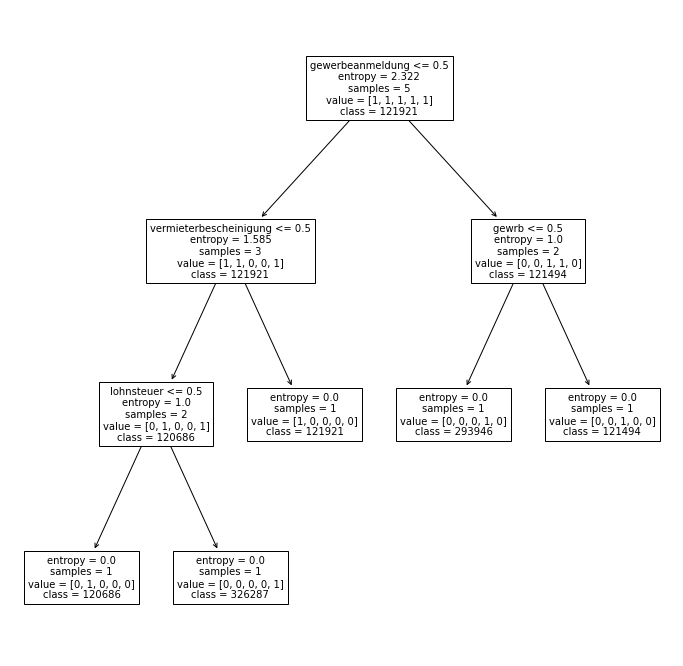

In [7]:
chatbot.printTree()
chatbot.plotTree()


In [ ]:
chatbot.matrix[0][0]

Logging

In [95]:
class Logger:
    
    def __init__(self, chatbot, eval_df):
        self.liste = []
        self.chatbot = chatbot
        self.eval_df = eval_df
    
    def getDataFrame(self): # TODO
        pass
    
    def log(self, ID, t, row, answer = None): 
        target_service = row["documentId"]
        
        dialogId = row["dialogId"]
        file = row["file"]
        
        service_name = row["name"]
        query = row["initialQuestion"]
        
        
        if answer is not None:

            
            nResults = len(self.chatbot.df.index)
            question = self.chatbot.generateQuestion()
            answer = answer

            rank = getRank(self.chatbot,target_service)# getRank(target_service)
            
            row = (file, dialogId, ID, t,  service_name, query, question, answer, rank, nResults)
        else:
            #nInitialResults = len(chatbot.df.index)
            #initialRank = np.nan
            row = (file, dialogId, ID, t, service_name, query, None, None, None, None)
        self.liste.append(row)
        #print(self.liste)

Execution

In [104]:
# Initialisierung Komponenten Chatbot
#solrhandler = sh.SolrHandler(20)
chatbot = DecisionTreeChatbot()

In [105]:
# Experiment durchlaufen und Loggen
lg = Logger(chatbot,eval)   

for (ID, row) in eval.iterrows():
    
    # fun
    query = row["initialQuestion"]
    target_service = row["documentId"]
    
    # Log
    try:
        chatbot.initQuery(query,False)
    except Exception as e:
        if(str(e) == 'response'): # TODO ??
            next
        elif(str(e) == 'no solr output'):
            next
        else:
            print(e)
    
    t = 0
    answer = findCorrectAnswer(chatbot, target_service)
    print(answer)
    lg.log(ID,t, row, answer)
    if answer is None:
        continue
    
    
    while chatbot.refine(answer):
        # log
        t += 1
        
        answer = findCorrectAnswer(chatbot, target_service)
        if answer is None: 
            break
        lg.log(ID, t, row,answer)

0    False
1    False
2     True
3    False
4    False
Name: id, dtype: bool
2
False
(array([2, 3, 4], dtype=int64),)
2     True
3    False
4    False
Name: id, dtype: bool
2
(array([2], dtype=int64),)
2    True
Name: id, dtype: bool
2
0    False
1    False
2    False
3    False
4    False
Name: id, dtype: bool
not any
None
0    False
1    False
2    False
3     True
4    False
Name: id, dtype: bool
3
False
(array([4], dtype=int64),)
4    False
Name: id, dtype: bool
not any
0     True
1    False
2    False
3    False
4    False
Name: id, dtype: bool
0
True
(array([0], dtype=int64),)
0    True
Name: id, dtype: bool
0
0    False
1    False
2    False
3    False
4    False
Name: id, dtype: bool
not any
None


In [ ]:
#query
#len(solrhandler.get_df_from_query(query))

In [106]:
log_df = pd.DataFrame(lg.liste, columns=["file","dialogId", "ID","t", "service_name", "query", "question", "answer", "rank", "nResults"])
log_df["rank"] = log_df["rank"]+1
log_df["t"] = log_df["t"] +1
log_df.head()

,file,dialogId,ID,t,service_name,query,question,answer,rank,nResults
0,20220131--quantEvalAllExcel.xlsx,4,0,1,Änderung/Wechsel der Hauptwohnung,Ummeldung,Geht es bei ihrem Anliegen um anmeldung?,False,3.0,5.0
1,20220131--quantEvalAllExcel.xlsx,4,0,2,Änderung/Wechsel der Hauptwohnung,Ummeldung,Geht es bei ihrem Anliegen um betriebsumzug?,True,3.0,3.0
2,20220131--quantEvalAllExcel.xlsx,4,0,3,Änderung/Wechsel der Hauptwohnung,Ummeldung,Geht es bei ihrem Anliegen um zweitwohnsitz?,False,3.0,1.0
3,20220131--quantEvalAllExcel.xlsx,4,1,1,Anmeldung einer Wohnung,Ummelden,None,None,NaN,NaN
4,20220131--quantEvalAllExcel.xlsx,19,2,1,Erstattung nach Infektionsschutzgesetz bei Tät...,Pcr test positiv brauche ich eine Krankschreib...,Geht es bei ihrem Anliegen um vertrauensperson?,False,4.0,5.0


Statistics

In [107]:
# avg Rank Improvement in turn t
log_df["rank_improvement"] = log_df.groupby(["ID"])["rank"].diff()
log_df.groupby(["t"])["rank_improvement"].mean()

t
1    NaN
2    0.0
3    0.0
Name: rank_improvement, dtype: float64

In [108]:
# avg nSuggestions Improvement in turn t
log_df["sugg_improvement"] = log_df.groupby(["ID"])["nResults"].diff()
log_df.groupby(["t"])["sugg_improvement"].mean()

t
1    NaN
2   -3.0
3   -2.0
Name: sugg_improvement, dtype: float64

In [109]:
# MRR ohne cluster refinement
df = log_df.loc[log_df["t"] == 1]
MRR_ohne = 1/(df["rank"].mean())
MRR_ohne

0.375

In [110]:
# MRR mit cluster refinement
df = log_df.groupby(["ID"]).last("t")
MRR_mit = 1/(df["rank"].mean())
MRR_mit
#df.head()

0.375

In [111]:
# avg Turns (Achtun!) -> chatbot geht noch nicht bis auf einzelnen service herunter weil je nachdem alle in einem cluster
print(log_df["t"].mean())

# bei durchschnittlich nResults
print(log_df.groupby(["ID"]).last("t")["nResults"].mean())

1.5
2.3333333333333335


In [112]:
log_df.dropna(subset = "answer").head(20)

,file,dialogId,ID,t,service_name,query,question,answer,rank,nResults,rank_improvement,sugg_improvement
0,20220131--quantEvalAllExcel.xlsx,4,0,1,Änderung/Wechsel der Hauptwohnung,Ummeldung,Geht es bei ihrem Anliegen um anmeldung?,False,3.0,5.0,NaN,NaN
1,20220131--quantEvalAllExcel.xlsx,4,0,2,Änderung/Wechsel der Hauptwohnung,Ummeldung,Geht es bei ihrem Anliegen um betriebsumzug?,True,3.0,3.0,0.0,-2.0
2,20220131--quantEvalAllExcel.xlsx,4,0,3,Änderung/Wechsel der Hauptwohnung,Ummeldung,Geht es bei ihrem Anliegen um zweitwohnsitz?,False,3.0,1.0,0.0,-2.0
4,20220131--quantEvalAllExcel.xlsx,19,2,1,Erstattung nach Infektionsschutzgesetz bei Tät...,Pcr test positiv brauche ich eine Krankschreib...,Geht es bei ihrem Anliegen um vertrauensperson?,False,4.0,5.0,NaN,NaN
5,20220131--quantEvalAllExcel.xlsx,19,3,1,Erstattung nach Infektionsschutzgesetz bei Tät...,Quarantäne Krankschreibung vom Arzt,Geht es bei ihrem Anliegen um ärztin?,True,1.0,5.0,NaN,NaN
6,20220131--quantEvalAllExcel.xlsx,19,3,2,Erstattung nach Infektionsschutzgesetz bei Tät...,Quarantäne Krankschreibung vom Arzt,Geht es bei ihrem Anliegen um ärztin?,True,1.0,1.0,0.0,-4.0


In [113]:
log_df["question"] is not None

True

In [114]:
chatbot.df_clus["ssdsLemma_processed"][0]

AttributeError: 'DecisionTreeChatbot' object has no attribute 'df_clus'

In [ ]:
chatbot.df_clus["ssdsLemma_processed"][1]

In [ ]:
chatbot.df